In [1]:
# conda install keras-tuner
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import seaborn as sns
sns.set()
from collections import Counter
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, f1_score, classification_report
# import pickle
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow.keras import losses
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import *
import keras_tuner as kt

2022-12-03 18:25:35.517788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### eth

In [3]:
regs = pd.read_csv("../Data/train_eth_selected_features.csv")
eth = pd.read_csv("../Data/ethereum_Data.csv")
for i in range(len(eth['Date'])):
    eth['Date'][i]  =  datetime.strptime(eth['Date'][i], '%Y/%m/%d')

eth = eth.set_index("Date")

/tmp/ipykernel_962023/475244478.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth['Date'][i]  =  datetime.strptime(eth['Date'][i], '%Y/%m/%d')


In [4]:
ethData = eth[regs.columns]

In [5]:
ethData['returns'] = ethData['priceUSD'].pct_change()

/tmp/ipykernel_962023/2709644231.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ethData['returns'] = ethData['priceUSD'].pct_change()


In [6]:
Data = ethData.drop(columns=['priceUSD'])
Data = Data[1:]

In [7]:
Data 

,activeaddresses90roc,confirmationtime,confirmationtime90roc,difficulty90roc,fee_to_reward90rocUSD,fee_to_rewardUSD,hashrate90roc,median_transaction_fee90rocUSD,mediantransactionvalue90rocUSD,mediantransactionvalueUSD,...,sentinusd90rocUSD,sentinusdUSD,size,size90roc,transactionfees90rocUSD,transactionfeesUSD,transactions90roc,transactionvalue90rocUSD,transactionvalueUSD,returns
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-02,68.156,0.283,-4.102,31.289,92.095,0.0684,42.295,43.084,64.299,1.348,...,33.650,250428,953.560,22.907,112.289,0.00204,38.345,-3.394,27.327,0.006250
2016-01-03,67.716,0.280,-2.435,32.266,60.229,0.0679,41.299,48.484,6.051,1.320,...,235.901,363640,955.046,23.805,70.505,0.00206,47.444,127.816,39.278,0.015528
2016-01-04,71.308,0.283,-5.691,32.784,94.471,0.0751,46.895,56.364,32.177,1.238,...,-52.432,149848,981.314,25.645,127.247,0.00219,46.702,-67.575,15.817,-0.009174
2016-01-05,71.818,0.281,-2.380,38.812,358.045,0.2060,49.564,359.484,-100.000,0.000,...,415.046,1010627,1396.000,72.720,231.035,0.00358,130.726,123.229,61.511,0.003086
2016-01-06,87.024,0.283,1.218,40.900,434.941,0.2310,47.170,360.138,-100.000,0.000,...,35.258,255146,1553.000,96.838,264.918,0.00380,146.520,-45.133,14.944,-0.001026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-25,-1.334,0.201,-12.856,-100.000,-15.546,2.1180,-100.000,6.214,0.000,0.000,...,-23.152,1634051131,68250.000,-21.055,11.363,1.70400,-4.659,-19.397,1635.000,-0.007506
2022-11-26,-6.811,0.201,-12.851,-100.000,-18.774,2.0300,-100.000,9.807,-100.000,0.000,...,-46.738,1167917265,71240.000,-20.897,15.063,1.78600,-8.786,-41.608,1249.000,0.021008
2022-11-27,-13.483,0.201,-11.622,-100.000,-38.242,1.9200,-100.000,-38.760,0.000,0.000,...,-68.602,1061082115,68460.000,-27.495,-28.381,1.82900,-18.636,-61.410,1204.000,0.000000


In [8]:
# divide X and Y
X = Data.iloc[:,0:]
#Y = Data['returns']   # 用returns的话就用这一行，然后把下一行comment掉
Y = ethData['priceUSD'].shift(-30)[1:] # 反之亦然

In [9]:
X.head(3)

,activeaddresses90roc,confirmationtime,confirmationtime90roc,difficulty90roc,fee_to_reward90rocUSD,fee_to_rewardUSD,hashrate90roc,median_transaction_fee90rocUSD,mediantransactionvalue90rocUSD,mediantransactionvalueUSD,...,sentinusd90rocUSD,sentinusdUSD,size,size90roc,transactionfees90rocUSD,transactionfeesUSD,transactions90roc,transactionvalue90rocUSD,transactionvalueUSD,returns
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-02,68.156,0.283,-4.102,31.289,92.095,0.0684,42.295,43.084,64.299,1.348,...,33.650,250428,953.560,22.907,112.289,0.00204,38.345,-3.394,27.327,0.006250
2016-01-03,67.716,0.280,-2.435,32.266,60.229,0.0679,41.299,48.484,6.051,1.320,...,235.901,363640,955.046,23.805,70.505,0.00206,47.444,127.816,39.278,0.015528
2016-01-04,71.308,0.283,-5.691,32.784,94.471,0.0751,46.895,56.364,32.177,1.238,...,-52.432,149848,981.314,25.645,127.247,0.00219,46.702,-67.575,15.817,-0.009174


In [10]:
# Split into three data sets
X_train = X['2016-01-01':'2019-12-31']
X_val = X['2020-01-01':'2021-05-31']
X_test = X['2021-06-01':'2023-01-01']

Y_train = Y['2016-01-01':'2019-12-31']
Y_val = Y['2020-01-01':'2021-05-31']
Y_test = Y['2021-06-01':'2023-01-01']

In [11]:
estimators=[]
estimators.append(['mixmax',MinMaxScaler()])
estimators.append(['robust',RobustScaler()])
scale=Pipeline(estimators,verbose=True)
scale.fit(X_train)

[Pipeline] ............ (step 1 of 2) Processing mixmax, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing robust, total=   0.0s


Pipeline(steps=[('mixmax', MinMaxScaler()), ['robust', RobustScaler()]],
         verbose=True)

In [12]:
X_train=scale.transform(X_train)
X_test=scale.transform(X_test)
X_val = scale.transform(X_val)

In [13]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [14]:
# define neural network model
shape=X.shape[1]
def build_model(hp, initializer='normal', activation='relu', NUM_FEATURES=shape):
    # create model
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
    model = Sequential()
    model.add(Dense(hp_units1, input_shape=(NUM_FEATURES,), kernel_initializer=initializer, activation=activation))
    model.add(Dense(hp_units2, activation=activation))
    model.add(Dense(hp_units3, activation=activation))
    model.add(Dense(1, activation=activation))
    # Compile model
    adam=keras.optimizers.Adam(lr=lr_schedule(0), amsgrad=True)
    #sgd=keras.optimizers.SGD(learning_rate=0.08, momentum=0.9, nesterov=False)
    model.compile(loss='logcosh', optimizer=adam, metrics=['mae'])
    return model

In [15]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    directory='eth_tune',
    project_name='ANN_TUNE'
)

tuner.search(X_train, Y_train, epochs=5000, validation_data=(X_val, Y_val))

Trial 10 Complete [00h 40m 35s]
val_mae: 311.19610595703125

Best val_mae So Far: 294.7487487792969
Total elapsed time: 04h 59m 50s
INFO:tensorflow:Oracle triggered exit


In [16]:
# Get the best hyperparameters.
best_hp = tuner.get_best_hyperparameters()[0]
# Build the model with the best hp.
regressor = build_model(best_hp)
# Fit with the entire dataset.
X_all = np.concatenate((X_train, X_val))
Y_all = np.concatenate((Y_train, Y_val))


Learning rate:  0.001


In [17]:
# best hyperparameters
best_hp

stop training when loss is not increasing

In [18]:
earlyStopping = EarlyStopping(monitor='loss', patience=1000,verbose=1, mode='auto')

In [19]:
regressor.fit(x=X_all, y=Y_all, epochs=5000, use_multiprocessing=True, callbacks=[earlyStopping])
# regressor=KerasRegressor(build_fn=sequential_model,epochs=5000,verbose=1, use_multiprocessing=True, callback=[earlyStopping])

Epoch 1/5000
62/62 [==============================] - 1s 14ms/step - loss: 252.1183 - mae: 252.8071
Epoch 2/5000
62/62 [==============================] - 0s 6ms/step - loss: 148.3554 - mae: 149.0403
Epoch 3/5000
62/62 [==============================] - 1s 9ms/step - loss: 132.4065 - mae: 133.0849
Epoch 4/5000
62/62 [==============================] - 0s 8ms/step - loss: 121.6561 - mae: 122.3287
Epoch 5/5000
62/62 [==============================] - 1s 10ms/step - loss: 114.4407 - mae: 115.1063
Epoch 6/5000
62/62 [==============================] - 1s 10ms/step - loss: 105.1248 - mae: 105.7892
Epoch 7/5000
62/62 [==============================] - 1s 11ms/step - loss: 100.0897 - mae: 100.7573
Epoch 8/5000
62/62 [==============================] - 1s 12ms/step - loss: 91.2298 - mae: 91.8964
Epoch 9/5000
62/62 [==============================] - 1s 10ms/step - loss: 87.0459 - mae: 87.7086
Epoch 10/5000
62/62 [==============================] - 1s 11ms/step - loss: 82.2305 - mae: 82.8930
Epoch 11

62/62 [==============================] - 1s 8ms/step - loss: 37.1305 - mae: 37.7658
Epoch 85/5000
62/62 [==============================] - 1s 14ms/step - loss: 35.6787 - mae: 36.3087
Epoch 86/5000
62/62 [==============================] - 1s 15ms/step - loss: 35.1666 - mae: 35.7953
Epoch 87/5000
62/62 [==============================] - 0s 8ms/step - loss: 38.7342 - mae: 39.3628
Epoch 88/5000
62/62 [==============================] - 0s 5ms/step - loss: 38.6171 - mae: 39.2477
Epoch 89/5000
62/62 [==============================] - 1s 9ms/step - loss: 40.1773 - mae: 40.8053
Epoch 90/5000
62/62 [==============================] - 1s 11ms/step - loss: 36.7332 - mae: 37.3641
Epoch 91/5000
62/62 [==============================] - 1s 12ms/step - loss: 34.3302 - mae: 34.9521
Epoch 92/5000
62/62 [==============================] - 1s 9ms/step - loss: 34.0705 - mae: 34.6972
Epoch 93/5000
62/62 [==============================] - 1s 12ms/step - loss: 34.0246 - mae: 34.6532
Epoch 94/5000
62/62 [========

62/62 [==============================] - 1s 8ms/step - loss: 25.9811 - mae: 26.5842
Epoch 167/5000
62/62 [==============================] - 0s 7ms/step - loss: 26.3816 - mae: 26.9913
Epoch 168/5000
62/62 [==============================] - 1s 8ms/step - loss: 25.6115 - mae: 26.2240
Epoch 169/5000
62/62 [==============================] - 0s 8ms/step - loss: 27.1999 - mae: 27.8068
Epoch 170/5000
62/62 [==============================] - 0s 5ms/step - loss: 25.8323 - mae: 26.4394
Epoch 171/5000
62/62 [==============================] - 0s 5ms/step - loss: 26.4600 - mae: 27.0673
Epoch 172/5000
62/62 [==============================] - 1s 16ms/step - loss: 30.1518 - mae: 30.7724
Epoch 173/5000
62/62 [==============================] - 1s 14ms/step - loss: 27.1193 - mae: 27.7278
Epoch 174/5000
62/62 [==============================] - 1s 14ms/step - loss: 24.7054 - mae: 25.3167
Epoch 175/5000
62/62 [==============================] - 1s 22ms/step - loss: 27.1806 - mae: 27.7879
Epoch 176/5000
62/62 

62/62 [==============================] - 1s 12ms/step - loss: 21.7534 - mae: 22.3442
Epoch 249/5000
62/62 [==============================] - 0s 5ms/step - loss: 20.6621 - mae: 21.2474
Epoch 250/5000
62/62 [==============================] - 1s 12ms/step - loss: 23.1550 - mae: 23.7618
Epoch 251/5000
62/62 [==============================] - 0s 5ms/step - loss: 21.9657 - mae: 22.5644
Epoch 252/5000
62/62 [==============================] - 1s 10ms/step - loss: 23.9268 - mae: 24.5322
Epoch 253/5000
62/62 [==============================] - 1s 11ms/step - loss: 22.0817 - mae: 22.6756
Epoch 254/5000
62/62 [==============================] - 1s 13ms/step - loss: 21.1271 - mae: 21.7270
Epoch 255/5000
62/62 [==============================] - 1s 23ms/step - loss: 19.5743 - mae: 20.1647
Epoch 256/5000
62/62 [==============================] - 0s 8ms/step - loss: 20.3815 - mae: 20.9730
Epoch 257/5000
62/62 [==============================] - 1s 24ms/step - loss: 22.3074 - mae: 22.9040
Epoch 258/5000
62/

62/62 [==============================] - 1s 10ms/step - loss: 17.8227 - mae: 18.4060
Epoch 331/5000
62/62 [==============================] - 1s 8ms/step - loss: 17.4890 - mae: 18.0683
Epoch 332/5000
62/62 [==============================] - 1s 13ms/step - loss: 20.6575 - mae: 21.2484
Epoch 333/5000
62/62 [==============================] - 1s 17ms/step - loss: 17.4595 - mae: 18.0351
Epoch 334/5000
62/62 [==============================] - 1s 9ms/step - loss: 17.3914 - mae: 17.9801
Epoch 335/5000
62/62 [==============================] - 0s 6ms/step - loss: 20.1845 - mae: 20.7724
Epoch 336/5000
62/62 [==============================] - 0s 6ms/step - loss: 19.4314 - mae: 20.0211
Epoch 337/5000
62/62 [==============================] - 1s 10ms/step - loss: 18.2506 - mae: 18.8456
Epoch 338/5000
62/62 [==============================] - 1s 10ms/step - loss: 17.8552 - mae: 18.4400
Epoch 339/5000
62/62 [==============================] - 1s 8ms/step - loss: 18.0311 - mae: 18.6213
Epoch 340/5000
62/62

62/62 [==============================] - 1s 11ms/step - loss: 14.4720 - mae: 15.0369
Epoch 413/5000
62/62 [==============================] - 1s 13ms/step - loss: 15.3116 - mae: 15.8822
Epoch 414/5000
62/62 [==============================] - 1s 12ms/step - loss: 18.1373 - mae: 18.7242
Epoch 415/5000
62/62 [==============================] - 1s 7ms/step - loss: 15.4203 - mae: 16.0020
Epoch 416/5000
62/62 [==============================] - 1s 12ms/step - loss: 15.6602 - mae: 16.2403
Epoch 417/5000
62/62 [==============================] - 1s 8ms/step - loss: 17.5106 - mae: 18.0892
Epoch 418/5000
62/62 [==============================] - 0s 7ms/step - loss: 16.9520 - mae: 17.5270
Epoch 419/5000
62/62 [==============================] - 1s 10ms/step - loss: 17.7801 - mae: 18.3579
Epoch 420/5000
62/62 [==============================] - 1s 10ms/step - loss: 15.5879 - mae: 16.1635
Epoch 421/5000
62/62 [==============================] - 1s 18ms/step - loss: 15.7909 - mae: 16.3638
Epoch 422/5000
62/

62/62 [==============================] - 0s 7ms/step - loss: 14.6098 - mae: 15.1848
Epoch 495/5000
62/62 [==============================] - 0s 8ms/step - loss: 13.4265 - mae: 13.9991
Epoch 496/5000
62/62 [==============================] - 1s 10ms/step - loss: 16.5157 - mae: 17.0976
Epoch 497/5000
62/62 [==============================] - 1s 15ms/step - loss: 13.8076 - mae: 14.3697
Epoch 498/5000
62/62 [==============================] - 1s 18ms/step - loss: 12.7270 - mae: 13.2920
Epoch 499/5000
62/62 [==============================] - 1s 10ms/step - loss: 16.1741 - mae: 16.7556
Epoch 500/5000
62/62 [==============================] - 1s 9ms/step - loss: 14.7758 - mae: 15.3582
Epoch 501/5000
62/62 [==============================] - 1s 12ms/step - loss: 14.2550 - mae: 14.8248
Epoch 502/5000
62/62 [==============================] - 1s 10ms/step - loss: 14.4271 - mae: 14.9980
Epoch 503/5000
62/62 [==============================] - 1s 15ms/step - loss: 14.5395 - mae: 15.1154
Epoch 504/5000
62/

62/62 [==============================] - 1s 9ms/step - loss: 12.0471 - mae: 12.6093
Epoch 577/5000
62/62 [==============================] - 1s 8ms/step - loss: 11.8840 - mae: 12.4410
Epoch 578/5000
62/62 [==============================] - 1s 15ms/step - loss: 12.1255 - mae: 12.6932
Epoch 579/5000
62/62 [==============================] - 1s 13ms/step - loss: 13.2692 - mae: 13.8401
Epoch 580/5000
62/62 [==============================] - 1s 9ms/step - loss: 12.0269 - mae: 12.5864
Epoch 581/5000
62/62 [==============================] - 1s 10ms/step - loss: 12.5855 - mae: 13.1394
Epoch 582/5000
62/62 [==============================] - 1s 12ms/step - loss: 13.7824 - mae: 14.3428
Epoch 583/5000
62/62 [==============================] - 1s 14ms/step - loss: 13.9395 - mae: 14.5136
Epoch 584/5000
62/62 [==============================] - 1s 9ms/step - loss: 12.1760 - mae: 12.7416
Epoch 585/5000
62/62 [==============================] - 1s 11ms/step - loss: 11.1553 - mae: 11.7154
Epoch 586/5000
62/6

62/62 [==============================] - 0s 7ms/step - loss: 10.4351 - mae: 10.9918
Epoch 659/5000
62/62 [==============================] - 1s 14ms/step - loss: 12.0877 - mae: 12.6490
Epoch 660/5000
62/62 [==============================] - 2s 27ms/step - loss: 10.7730 - mae: 11.3278
Epoch 661/5000
62/62 [==============================] - 1s 12ms/step - loss: 10.2965 - mae: 10.8509
Epoch 662/5000
62/62 [==============================] - 1s 14ms/step - loss: 11.4926 - mae: 12.0496
Epoch 663/5000
62/62 [==============================] - 1s 11ms/step - loss: 11.5636 - mae: 12.1202
Epoch 664/5000
62/62 [==============================] - 1s 20ms/step - loss: 11.3760 - mae: 11.9325
Epoch 665/5000
62/62 [==============================] - 1s 18ms/step - loss: 13.9628 - mae: 14.5389
Epoch 666/5000
62/62 [==============================] - 1s 13ms/step - loss: 13.7635 - mae: 14.3357
Epoch 667/5000
62/62 [==============================] - 1s 14ms/step - loss: 11.1476 - mae: 11.7095
Epoch 668/5000
6

62/62 [==============================] - 1s 13ms/step - loss: 9.9124 - mae: 10.4620
Epoch 741/5000
62/62 [==============================] - 1s 13ms/step - loss: 9.7560 - mae: 10.3053
Epoch 742/5000
62/62 [==============================] - 1s 21ms/step - loss: 9.8270 - mae: 10.3747
Epoch 743/5000
62/62 [==============================] - 1s 18ms/step - loss: 10.7410 - mae: 11.2954
Epoch 744/5000
62/62 [==============================] - 1s 9ms/step - loss: 10.1586 - mae: 10.7039
Epoch 745/5000
62/62 [==============================] - 1s 13ms/step - loss: 10.5511 - mae: 11.1047
Epoch 746/5000
62/62 [==============================] - 1s 11ms/step - loss: 9.7745 - mae: 10.3222
Epoch 747/5000
62/62 [==============================] - 0s 7ms/step - loss: 10.5065 - mae: 11.0647
Epoch 748/5000
62/62 [==============================] - 1s 10ms/step - loss: 10.1180 - mae: 10.6640
Epoch 749/5000
62/62 [==============================] - 1s 15ms/step - loss: 12.2185 - mae: 12.7867
Epoch 750/5000
62/62 

62/62 [==============================] - 0s 6ms/step - loss: 9.7966 - mae: 10.3397
Epoch 823/5000
62/62 [==============================] - 1s 10ms/step - loss: 13.4812 - mae: 14.0385
Epoch 824/5000
62/62 [==============================] - 1s 9ms/step - loss: 9.8862 - mae: 10.4291
Epoch 825/5000
62/62 [==============================] - 0s 7ms/step - loss: 12.3069 - mae: 12.8628
Epoch 826/5000
62/62 [==============================] - 0s 7ms/step - loss: 9.7055 - mae: 10.2526
Epoch 827/5000
62/62 [==============================] - 0s 8ms/step - loss: 10.0925 - mae: 10.6354
Epoch 828/5000
62/62 [==============================] - 1s 11ms/step - loss: 8.2272 - mae: 8.7589
Epoch 829/5000
62/62 [==============================] - 1s 17ms/step - loss: 10.3923 - mae: 10.9334
Epoch 830/5000
62/62 [==============================] - 1s 14ms/step - loss: 9.4764 - mae: 10.0193
Epoch 831/5000
62/62 [==============================] - 1s 14ms/step - loss: 9.7897 - mae: 10.3368
Epoch 832/5000
62/62 [=====

62/62 [==============================] - 1s 9ms/step - loss: 8.0044 - mae: 8.5451
Epoch 906/5000
62/62 [==============================] - 1s 12ms/step - loss: 11.0283 - mae: 11.5927
Epoch 907/5000
62/62 [==============================] - 0s 8ms/step - loss: 8.3871 - mae: 8.9230
Epoch 908/5000
62/62 [==============================] - 1s 9ms/step - loss: 9.3765 - mae: 9.9079
Epoch 909/5000
62/62 [==============================] - 1s 11ms/step - loss: 8.3975 - mae: 8.9311
Epoch 910/5000
62/62 [==============================] - 0s 7ms/step - loss: 8.0287 - mae: 8.5595
Epoch 911/5000
62/62 [==============================] - 1s 16ms/step - loss: 8.9367 - mae: 9.4603
Epoch 912/5000
62/62 [==============================] - 0s 6ms/step - loss: 8.8235 - mae: 9.3634
Epoch 913/5000
62/62 [==============================] - 0s 7ms/step - loss: 10.0588 - mae: 10.6052
Epoch 914/5000
62/62 [==============================] - 1s 21ms/step - loss: 8.5711 - mae: 9.1141
Epoch 915/5000
62/62 [===============

62/62 [==============================] - 1s 8ms/step - loss: 10.0741 - mae: 10.6245
Epoch 989/5000
62/62 [==============================] - 1s 11ms/step - loss: 8.4557 - mae: 8.9897
Epoch 990/5000
62/62 [==============================] - 1s 9ms/step - loss: 9.4228 - mae: 9.9779
Epoch 991/5000
62/62 [==============================] - 1s 11ms/step - loss: 8.5305 - mae: 9.0731
Epoch 992/5000
62/62 [==============================] - 1s 8ms/step - loss: 9.0812 - mae: 9.6183
Epoch 993/5000
62/62 [==============================] - 0s 8ms/step - loss: 11.4354 - mae: 11.9908
Epoch 994/5000
62/62 [==============================] - 1s 11ms/step - loss: 8.5530 - mae: 9.0871
Epoch 995/5000
62/62 [==============================] - 0s 5ms/step - loss: 10.5782 - mae: 11.1462
Epoch 996/5000
62/62 [==============================] - 0s 7ms/step - loss: 10.4661 - mae: 11.0353
Epoch 997/5000
62/62 [==============================] - 0s 5ms/step - loss: 10.5878 - mae: 11.1582
Epoch 998/5000
62/62 [==========

62/62 [==============================] - 1s 13ms/step - loss: 7.7976 - mae: 8.3324
Epoch 1072/5000
62/62 [==============================] - 0s 6ms/step - loss: 9.8099 - mae: 10.3611
Epoch 1073/5000
62/62 [==============================] - 0s 7ms/step - loss: 8.6117 - mae: 9.1536
Epoch 1074/5000
62/62 [==============================] - 1s 9ms/step - loss: 7.8286 - mae: 8.3707
Epoch 1075/5000
62/62 [==============================] - 0s 7ms/step - loss: 7.9242 - mae: 8.4557
Epoch 1076/5000
62/62 [==============================] - 0s 7ms/step - loss: 8.5294 - mae: 9.0672
Epoch 1077/5000
62/62 [==============================] - 0s 6ms/step - loss: 9.8904 - mae: 10.4402
Epoch 1078/5000
62/62 [==============================] - 1s 10ms/step - loss: 9.7165 - mae: 10.2558
Epoch 1079/5000
62/62 [==============================] - 0s 8ms/step - loss: 8.5336 - mae: 9.0773
Epoch 1080/5000
62/62 [==============================] - 1s 10ms/step - loss: 7.8289 - mae: 8.3573
Epoch 1081/5000
62/62 [=======

62/62 [==============================] - 1s 10ms/step - loss: 7.6381 - mae: 8.1684
Epoch 1155/5000
62/62 [==============================] - 1s 8ms/step - loss: 8.2946 - mae: 8.8295
Epoch 1156/5000
62/62 [==============================] - 1s 8ms/step - loss: 8.0298 - mae: 8.5560
Epoch 1157/5000
62/62 [==============================] - 0s 8ms/step - loss: 8.4020 - mae: 8.9319
Epoch 1158/5000
62/62 [==============================] - 1s 8ms/step - loss: 7.9186 - mae: 8.4575
Epoch 1159/5000
62/62 [==============================] - 1s 9ms/step - loss: 8.0829 - mae: 8.6207
Epoch 1160/5000
62/62 [==============================] - 1s 11ms/step - loss: 8.6228 - mae: 9.1548
Epoch 1161/5000
62/62 [==============================] - 1s 11ms/step - loss: 7.8840 - mae: 8.4227
Epoch 1162/5000
62/62 [==============================] - 1s 15ms/step - loss: 9.3671 - mae: 9.9150
Epoch 1163/5000
62/62 [==============================] - 1s 21ms/step - loss: 9.2027 - mae: 9.7516
Epoch 1164/5000
62/62 [========

62/62 [==============================] - 0s 6ms/step - loss: 10.2995 - mae: 10.8520
Epoch 1238/5000
62/62 [==============================] - 0s 6ms/step - loss: 8.6603 - mae: 9.2142
Epoch 1239/5000
62/62 [==============================] - 0s 7ms/step - loss: 7.2495 - mae: 7.7799
Epoch 1240/5000
62/62 [==============================] - 1s 9ms/step - loss: 8.5867 - mae: 9.1330
Epoch 1241/5000
62/62 [==============================] - 0s 6ms/step - loss: 9.3260 - mae: 9.8736
Epoch 1242/5000
62/62 [==============================] - 0s 7ms/step - loss: 8.5770 - mae: 9.1087
Epoch 1243/5000
62/62 [==============================] - 0s 6ms/step - loss: 9.0516 - mae: 9.5993
Epoch 1244/5000
62/62 [==============================] - 0s 8ms/step - loss: 8.7062 - mae: 9.2529
Epoch 1245/5000
62/62 [==============================] - 1s 9ms/step - loss: 9.2714 - mae: 9.8120
Epoch 1246/5000
62/62 [==============================] - 1s 11ms/step - loss: 7.9052 - mae: 8.4570
Epoch 1247/5000
62/62 [==========

62/62 [==============================] - 1s 9ms/step - loss: 6.9935 - mae: 7.5052
Epoch 1321/5000
62/62 [==============================] - 1s 9ms/step - loss: 7.2856 - mae: 7.8092
Epoch 1322/5000
62/62 [==============================] - 1s 10ms/step - loss: 6.9516 - mae: 7.4763
Epoch 1323/5000
62/62 [==============================] - 1s 14ms/step - loss: 7.5512 - mae: 8.0827
Epoch 1324/5000
62/62 [==============================] - 1s 10ms/step - loss: 7.5776 - mae: 8.1175
Epoch 1325/5000
62/62 [==============================] - 1s 8ms/step - loss: 6.6824 - mae: 7.2139
Epoch 1326/5000
62/62 [==============================] - 0s 5ms/step - loss: 7.0386 - mae: 7.5725
Epoch 1327/5000
62/62 [==============================] - 0s 5ms/step - loss: 6.4638 - mae: 6.9727
Epoch 1328/5000
62/62 [==============================] - 0s 5ms/step - loss: 8.1499 - mae: 8.6782
Epoch 1329/5000
62/62 [==============================] - 0s 6ms/step - loss: 8.5985 - mae: 9.1381
Epoch 1330/5000
62/62 [==========

62/62 [==============================] - 1s 23ms/step - loss: 6.4875 - mae: 7.0150
Epoch 1404/5000
62/62 [==============================] - 1s 18ms/step - loss: 7.4951 - mae: 8.0219
Epoch 1405/5000
62/62 [==============================] - 0s 7ms/step - loss: 6.4265 - mae: 6.9477
Epoch 1406/5000
62/62 [==============================] - 1s 9ms/step - loss: 6.4559 - mae: 6.9719
Epoch 1407/5000
62/62 [==============================] - 1s 13ms/step - loss: 8.6619 - mae: 9.1940
Epoch 1408/5000
62/62 [==============================] - 1s 9ms/step - loss: 8.4849 - mae: 9.0427
Epoch 1409/5000
62/62 [==============================] - 1s 9ms/step - loss: 7.2891 - mae: 7.8190
Epoch 1410/5000
62/62 [==============================] - 1s 11ms/step - loss: 7.6019 - mae: 8.1612
Epoch 1411/5000
62/62 [==============================] - 1s 15ms/step - loss: 8.2094 - mae: 8.7465
Epoch 1412/5000
62/62 [==============================] - 1s 10ms/step - loss: 8.0478 - mae: 8.5860
Epoch 1413/5000
62/62 [=======

62/62 [==============================] - 1s 9ms/step - loss: 6.6874 - mae: 7.2053
Epoch 1487/5000
62/62 [==============================] - 0s 6ms/step - loss: 7.3722 - mae: 7.8995
Epoch 1488/5000
62/62 [==============================] - 1s 13ms/step - loss: 7.1563 - mae: 7.6876
Epoch 1489/5000
62/62 [==============================] - 1s 17ms/step - loss: 7.2136 - mae: 7.7484
Epoch 1490/5000
62/62 [==============================] - 1s 20ms/step - loss: 6.7741 - mae: 7.3057
Epoch 1491/5000
62/62 [==============================] - 1s 11ms/step - loss: 6.4649 - mae: 6.9890
Epoch 1492/5000
62/62 [==============================] - 1s 12ms/step - loss: 6.8616 - mae: 7.3888
Epoch 1493/5000
62/62 [==============================] - 0s 7ms/step - loss: 6.5506 - mae: 7.0739
Epoch 1494/5000
62/62 [==============================] - 1s 11ms/step - loss: 6.8847 - mae: 7.4167
Epoch 1495/5000
62/62 [==============================] - 1s 8ms/step - loss: 7.1765 - mae: 7.7025
Epoch 1496/5000
62/62 [=======

62/62 [==============================] - 1s 12ms/step - loss: 6.7550 - mae: 7.2777
Epoch 1570/5000
62/62 [==============================] - 1s 9ms/step - loss: 6.1879 - mae: 6.7032
Epoch 1571/5000
62/62 [==============================] - 0s 8ms/step - loss: 5.7254 - mae: 6.2304
Epoch 1572/5000
62/62 [==============================] - 1s 11ms/step - loss: 5.1429 - mae: 5.6406
Epoch 1573/5000
62/62 [==============================] - 0s 8ms/step - loss: 6.0338 - mae: 6.5469
Epoch 1574/5000
62/62 [==============================] - 0s 8ms/step - loss: 5.5447 - mae: 6.0455
Epoch 1575/5000
62/62 [==============================] - 0s 6ms/step - loss: 6.7207 - mae: 7.2485
Epoch 1576/5000
62/62 [==============================] - 1s 8ms/step - loss: 6.2537 - mae: 6.7811
Epoch 1577/5000
62/62 [==============================] - 1s 11ms/step - loss: 6.0722 - mae: 6.5817
Epoch 1578/5000
62/62 [==============================] - 1s 14ms/step - loss: 6.6957 - mae: 7.2243
Epoch 1579/5000
62/62 [=========

62/62 [==============================] - 0s 7ms/step - loss: 6.1963 - mae: 6.7140
Epoch 1653/5000
62/62 [==============================] - 1s 8ms/step - loss: 6.7944 - mae: 7.3247
Epoch 1654/5000
62/62 [==============================] - 1s 12ms/step - loss: 5.2191 - mae: 5.7324
Epoch 1655/5000
62/62 [==============================] - 1s 13ms/step - loss: 5.1365 - mae: 5.6419
Epoch 1656/5000
62/62 [==============================] - 1s 19ms/step - loss: 6.4096 - mae: 6.9217
Epoch 1657/5000
62/62 [==============================] - 1s 15ms/step - loss: 5.9588 - mae: 6.4725
Epoch 1658/5000
62/62 [==============================] - 0s 6ms/step - loss: 6.2024 - mae: 6.7118
Epoch 1659/5000
62/62 [==============================] - 0s 6ms/step - loss: 8.1849 - mae: 8.7178
Epoch 1660/5000
62/62 [==============================] - 0s 6ms/step - loss: 8.7131 - mae: 9.2703
Epoch 1661/5000
62/62 [==============================] - 0s 6ms/step - loss: 6.3155 - mae: 6.8482
Epoch 1662/5000
62/62 [=========

62/62 [==============================] - 1s 11ms/step - loss: 6.2498 - mae: 6.7566
Epoch 1736/5000
62/62 [==============================] - 0s 7ms/step - loss: 7.1542 - mae: 7.6866
Epoch 1737/5000
62/62 [==============================] - 1s 17ms/step - loss: 5.7841 - mae: 6.2899
Epoch 1738/5000
62/62 [==============================] - 1s 9ms/step - loss: 6.3719 - mae: 6.8963
Epoch 1739/5000
62/62 [==============================] - 1s 13ms/step - loss: 5.5486 - mae: 6.0524
Epoch 1740/5000
62/62 [==============================] - 1s 9ms/step - loss: 5.2305 - mae: 5.7307
Epoch 1741/5000
62/62 [==============================] - 0s 5ms/step - loss: 7.2485 - mae: 7.7763
Epoch 1742/5000
62/62 [==============================] - 1s 11ms/step - loss: 6.2930 - mae: 6.8129
Epoch 1743/5000
62/62 [==============================] - 0s 5ms/step - loss: 6.0518 - mae: 6.5843
Epoch 1744/5000
62/62 [==============================] - 0s 5ms/step - loss: 6.0161 - mae: 6.5132
Epoch 1745/5000
62/62 [=========

62/62 [==============================] - 0s 6ms/step - loss: 5.9870 - mae: 6.4988
Epoch 1819/5000
62/62 [==============================] - 0s 6ms/step - loss: 5.2111 - mae: 5.7196
Epoch 1820/5000
62/62 [==============================] - 0s 6ms/step - loss: 5.0831 - mae: 5.5827
Epoch 1821/5000
62/62 [==============================] - 0s 6ms/step - loss: 5.6950 - mae: 6.2014
Epoch 1822/5000
62/62 [==============================] - 0s 6ms/step - loss: 5.4301 - mae: 5.9198
Epoch 1823/5000
62/62 [==============================] - 1s 9ms/step - loss: 5.7931 - mae: 6.2909
Epoch 1824/5000
62/62 [==============================] - 1s 10ms/step - loss: 5.4977 - mae: 6.0049
Epoch 1825/5000
62/62 [==============================] - 1s 12ms/step - loss: 6.6940 - mae: 7.2042
Epoch 1826/5000
62/62 [==============================] - 0s 7ms/step - loss: 6.5469 - mae: 7.0645
Epoch 1827/5000
62/62 [==============================] - 0s 6ms/step - loss: 5.5471 - mae: 6.0561
Epoch 1828/5000
62/62 [===========

62/62 [==============================] - 1s 21ms/step - loss: 6.5077 - mae: 7.0328
Epoch 1902/5000
62/62 [==============================] - 1s 12ms/step - loss: 6.9862 - mae: 7.5206
Epoch 1903/5000
62/62 [==============================] - 1s 10ms/step - loss: 6.7330 - mae: 7.2694
Epoch 1904/5000
62/62 [==============================] - 1s 10ms/step - loss: 5.4167 - mae: 5.9142
Epoch 1905/5000
62/62 [==============================] - 1s 11ms/step - loss: 5.0109 - mae: 5.5042
Epoch 1906/5000
62/62 [==============================] - 1s 9ms/step - loss: 5.6076 - mae: 6.1130
Epoch 1907/5000
62/62 [==============================] - 1s 10ms/step - loss: 7.3513 - mae: 7.8797
Epoch 1908/5000
62/62 [==============================] - 1s 8ms/step - loss: 6.2715 - mae: 6.7946
Epoch 1909/5000
62/62 [==============================] - 1s 9ms/step - loss: 6.7807 - mae: 7.3089
Epoch 1910/5000
62/62 [==============================] - 1s 9ms/step - loss: 6.3617 - mae: 6.8886
Epoch 1911/5000
62/62 [=======

62/62 [==============================] - 0s 8ms/step - loss: 5.9519 - mae: 6.4683
Epoch 1985/5000
62/62 [==============================] - 1s 10ms/step - loss: 7.1051 - mae: 7.6297
Epoch 1986/5000
62/62 [==============================] - 0s 7ms/step - loss: 5.5795 - mae: 6.1022
Epoch 1987/5000
62/62 [==============================] - 1s 8ms/step - loss: 5.0863 - mae: 5.5838
Epoch 1988/5000
62/62 [==============================] - 1s 9ms/step - loss: 6.2390 - mae: 6.7667
Epoch 1989/5000
62/62 [==============================] - 1s 8ms/step - loss: 5.9136 - mae: 6.4338
Epoch 1990/5000
62/62 [==============================] - 1s 9ms/step - loss: 5.6507 - mae: 6.1687
Epoch 1991/5000
62/62 [==============================] - 0s 8ms/step - loss: 5.7958 - mae: 6.3002
Epoch 1992/5000
62/62 [==============================] - 0s 8ms/step - loss: 4.8207 - mae: 5.3128
Epoch 1993/5000
62/62 [==============================] - 1s 8ms/step - loss: 5.3336 - mae: 5.8243
Epoch 1994/5000
62/62 [============

62/62 [==============================] - 0s 6ms/step - loss: 5.9438 - mae: 6.4521
Epoch 2068/5000
62/62 [==============================] - 1s 8ms/step - loss: 6.2621 - mae: 6.7982
Epoch 2069/5000
62/62 [==============================] - 1s 10ms/step - loss: 5.0678 - mae: 5.5726
Epoch 2070/5000
62/62 [==============================] - 1s 12ms/step - loss: 5.5078 - mae: 6.0209
Epoch 2071/5000
62/62 [==============================] - 1s 19ms/step - loss: 5.2390 - mae: 5.7500
Epoch 2072/5000
62/62 [==============================] - 1s 12ms/step - loss: 5.8267 - mae: 6.3407
Epoch 2073/5000
62/62 [==============================] - 1s 21ms/step - loss: 4.8069 - mae: 5.3116
Epoch 2074/5000
62/62 [==============================] - 1s 12ms/step - loss: 6.2995 - mae: 6.8253
Epoch 2075/5000
62/62 [==============================] - 0s 7ms/step - loss: 5.5452 - mae: 6.0537
Epoch 2076/5000
62/62 [==============================] - 1s 12ms/step - loss: 5.5132 - mae: 6.0121
Epoch 2077/5000
62/62 [======

62/62 [==============================] - 1s 13ms/step - loss: 4.2972 - mae: 4.7898
Epoch 2151/5000
62/62 [==============================] - 1s 12ms/step - loss: 4.6078 - mae: 5.1124
Epoch 2152/5000
62/62 [==============================] - 1s 10ms/step - loss: 5.2614 - mae: 5.7720
Epoch 2153/5000
62/62 [==============================] - 1s 14ms/step - loss: 6.0304 - mae: 6.5402
Epoch 2154/5000
62/62 [==============================] - 1s 12ms/step - loss: 5.1829 - mae: 5.6986
Epoch 2155/5000
62/62 [==============================] - 1s 9ms/step - loss: 5.7540 - mae: 6.2663
Epoch 2156/5000
62/62 [==============================] - 1s 8ms/step - loss: 5.0049 - mae: 5.5009
Epoch 2157/5000
62/62 [==============================] - 1s 17ms/step - loss: 6.0462 - mae: 6.5540
Epoch 2158/5000
62/62 [==============================] - 1s 10ms/step - loss: 5.8888 - mae: 6.4140
Epoch 2159/5000
62/62 [==============================] - 0s 7ms/step - loss: 5.5248 - mae: 6.0415
Epoch 2160/5000
62/62 [======

62/62 [==============================] - 1s 16ms/step - loss: 5.1607 - mae: 5.6654
Epoch 2234/5000
62/62 [==============================] - 1s 14ms/step - loss: 5.4581 - mae: 5.9784
Epoch 2235/5000
62/62 [==============================] - 1s 17ms/step - loss: 4.3927 - mae: 4.8865
Epoch 2236/5000
62/62 [==============================] - 1s 14ms/step - loss: 4.5965 - mae: 5.0905
Epoch 2237/5000
62/62 [==============================] - 1s 14ms/step - loss: 4.8206 - mae: 5.3157
Epoch 2238/5000
62/62 [==============================] - 0s 5ms/step - loss: 4.9211 - mae: 5.4236
Epoch 2239/5000
62/62 [==============================] - 1s 9ms/step - loss: 5.1242 - mae: 5.6202
Epoch 2240/5000
62/62 [==============================] - 1s 12ms/step - loss: 5.0521 - mae: 5.5569
Epoch 2241/5000
62/62 [==============================] - 0s 7ms/step - loss: 5.6362 - mae: 6.1667
Epoch 2242/5000
62/62 [==============================] - 0s 8ms/step - loss: 5.5451 - mae: 6.0627
Epoch 2243/5000
62/62 [=======

62/62 [==============================] - 1s 11ms/step - loss: 4.3843 - mae: 4.8737
Epoch 2317/5000
62/62 [==============================] - 1s 10ms/step - loss: 4.6382 - mae: 5.1291
Epoch 2318/5000
62/62 [==============================] - 0s 7ms/step - loss: 6.0968 - mae: 6.6130
Epoch 2319/5000
62/62 [==============================] - 1s 16ms/step - loss: 4.2150 - mae: 4.7016
Epoch 2320/5000
62/62 [==============================] - 1s 12ms/step - loss: 4.7593 - mae: 5.2673
Epoch 2321/5000
62/62 [==============================] - 0s 7ms/step - loss: 4.7031 - mae: 5.1937
Epoch 2322/5000
62/62 [==============================] - 0s 7ms/step - loss: 4.7338 - mae: 5.2327
Epoch 2323/5000
62/62 [==============================] - 1s 10ms/step - loss: 4.5129 - mae: 5.0065
Epoch 2324/5000
62/62 [==============================] - 1s 13ms/step - loss: 4.1894 - mae: 4.6689
Epoch 2325/5000
62/62 [==============================] - 1s 15ms/step - loss: 5.5645 - mae: 6.0556
Epoch 2326/5000
62/62 [======

62/62 [==============================] - 0s 7ms/step - loss: 5.3543 - mae: 5.8633
Epoch 2400/5000
62/62 [==============================] - 1s 8ms/step - loss: 5.0928 - mae: 5.5855
Epoch 2401/5000
62/62 [==============================] - 0s 6ms/step - loss: 4.7718 - mae: 5.2768
Epoch 2402/5000
62/62 [==============================] - 0s 6ms/step - loss: 4.4811 - mae: 4.9769
Epoch 2403/5000
62/62 [==============================] - 1s 9ms/step - loss: 4.1875 - mae: 4.6790
Epoch 2404/5000
62/62 [==============================] - 1s 11ms/step - loss: 4.0807 - mae: 4.5641
Epoch 2405/5000
62/62 [==============================] - 1s 8ms/step - loss: 4.2744 - mae: 4.7655
Epoch 2406/5000
62/62 [==============================] - 1s 15ms/step - loss: 5.3638 - mae: 5.8692
Epoch 2407/5000
62/62 [==============================] - 0s 8ms/step - loss: 5.5047 - mae: 6.0173
Epoch 2408/5000
62/62 [==============================] - 0s 7ms/step - loss: 4.9557 - mae: 5.4580
Epoch 2409/5000
62/62 [===========

62/62 [==============================] - 0s 7ms/step - loss: 5.0540 - mae: 5.5521
Epoch 2483/5000
62/62 [==============================] - 1s 8ms/step - loss: 4.6305 - mae: 5.1261
Epoch 2484/5000
62/62 [==============================] - 1s 9ms/step - loss: 4.9588 - mae: 5.4823
Epoch 2485/5000
62/62 [==============================] - 1s 11ms/step - loss: 5.5247 - mae: 6.0434
Epoch 2486/5000
62/62 [==============================] - 0s 7ms/step - loss: 6.4572 - mae: 6.9888
Epoch 2487/5000
62/62 [==============================] - 0s 5ms/step - loss: 4.6598 - mae: 5.1631
Epoch 2488/5000
62/62 [==============================] - 1s 8ms/step - loss: 5.0997 - mae: 5.6071
Epoch 2489/5000
62/62 [==============================] - 1s 9ms/step - loss: 4.4713 - mae: 4.9548
Epoch 2490/5000
62/62 [==============================] - 0s 5ms/step - loss: 3.9242 - mae: 4.4062
Epoch 2491/5000
62/62 [==============================] - 0s 5ms/step - loss: 5.5061 - mae: 6.0111
Epoch 2492/5000
62/62 [============

62/62 [==============================] - 0s 5ms/step - loss: 4.4950 - mae: 4.9844
Epoch 2566/5000
62/62 [==============================] - 1s 11ms/step - loss: 3.7497 - mae: 4.2161
Epoch 2567/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.6223 - mae: 4.0838
Epoch 2568/5000
62/62 [==============================] - 0s 7ms/step - loss: 4.2314 - mae: 4.7135
Epoch 2569/5000
62/62 [==============================] - 0s 6ms/step - loss: 3.4526 - mae: 3.9327
Epoch 2570/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.7264 - mae: 4.2027
Epoch 2571/5000
62/62 [==============================] - 0s 7ms/step - loss: 4.1048 - mae: 4.5903
Epoch 2572/5000
62/62 [==============================] - 1s 12ms/step - loss: 5.3218 - mae: 5.8229
Epoch 2573/5000
62/62 [==============================] - 0s 7ms/step - loss: 4.1406 - mae: 4.6319
Epoch 2574/5000
62/62 [==============================] - 2s 25ms/step - loss: 4.4859 - mae: 4.9864
Epoch 2575/5000
62/62 [==========

62/62 [==============================] - 0s 6ms/step - loss: 4.6578 - mae: 5.1617
Epoch 2649/5000
62/62 [==============================] - 0s 7ms/step - loss: 4.5105 - mae: 5.0075
Epoch 2650/5000
62/62 [==============================] - 1s 10ms/step - loss: 4.1153 - mae: 4.6019
Epoch 2651/5000
62/62 [==============================] - 1s 8ms/step - loss: 4.6606 - mae: 5.1568
Epoch 2652/5000
62/62 [==============================] - 0s 7ms/step - loss: 4.5164 - mae: 5.0304
Epoch 2653/5000
62/62 [==============================] - 0s 7ms/step - loss: 4.7021 - mae: 5.2109
Epoch 2654/5000
62/62 [==============================] - 0s 8ms/step - loss: 4.1056 - mae: 4.5941
Epoch 2655/5000
62/62 [==============================] - 1s 13ms/step - loss: 4.4913 - mae: 4.9861
Epoch 2656/5000
62/62 [==============================] - 1s 12ms/step - loss: 5.4760 - mae: 5.9952
Epoch 2657/5000
62/62 [==============================] - 1s 18ms/step - loss: 4.9252 - mae: 5.4417
Epoch 2658/5000
62/62 [=========

62/62 [==============================] - 1s 13ms/step - loss: 4.2350 - mae: 4.7226
Epoch 2732/5000
62/62 [==============================] - 1s 9ms/step - loss: 4.4905 - mae: 4.9875
Epoch 2733/5000
62/62 [==============================] - 0s 7ms/step - loss: 4.5187 - mae: 5.0092
Epoch 2734/5000
62/62 [==============================] - 1s 8ms/step - loss: 3.4041 - mae: 3.8629
Epoch 2735/5000
62/62 [==============================] - 1s 8ms/step - loss: 3.7354 - mae: 4.2032
Epoch 2736/5000
62/62 [==============================] - 1s 13ms/step - loss: 3.9220 - mae: 4.3992
Epoch 2737/5000
62/62 [==============================] - 1s 9ms/step - loss: 4.8704 - mae: 5.3732
Epoch 2738/5000
62/62 [==============================] - 1s 17ms/step - loss: 3.9078 - mae: 4.3879
Epoch 2739/5000
62/62 [==============================] - 1s 9ms/step - loss: 4.5905 - mae: 5.0999
Epoch 2740/5000
62/62 [==============================] - 0s 6ms/step - loss: 3.3763 - mae: 3.8520
Epoch 2741/5000
62/62 [==========

62/62 [==============================] - 0s 7ms/step - loss: 4.0420 - mae: 4.5200
Epoch 2815/5000
62/62 [==============================] - 1s 8ms/step - loss: 4.5890 - mae: 5.0875
Epoch 2816/5000
62/62 [==============================] - 1s 8ms/step - loss: 4.3583 - mae: 4.8641
Epoch 2817/5000
62/62 [==============================] - 1s 11ms/step - loss: 4.0825 - mae: 4.5558
Epoch 2818/5000
62/62 [==============================] - 1s 9ms/step - loss: 5.6009 - mae: 6.1138
Epoch 2819/5000
62/62 [==============================] - 1s 11ms/step - loss: 5.0108 - mae: 5.5245
Epoch 2820/5000
62/62 [==============================] - 1s 8ms/step - loss: 4.2557 - mae: 4.7491
Epoch 2821/5000
62/62 [==============================] - 1s 11ms/step - loss: 4.2643 - mae: 4.7452
Epoch 2822/5000
62/62 [==============================] - 1s 8ms/step - loss: 4.4547 - mae: 4.9396
Epoch 2823/5000
62/62 [==============================] - 1s 9ms/step - loss: 4.2303 - mae: 4.7268
Epoch 2824/5000
62/62 [==========

62/62 [==============================] - 0s 6ms/step - loss: 4.8455 - mae: 5.3423
Epoch 2898/5000
62/62 [==============================] - 1s 8ms/step - loss: 4.2864 - mae: 4.7734
Epoch 2899/5000
62/62 [==============================] - 1s 11ms/step - loss: 4.1875 - mae: 4.6584
Epoch 2900/5000
62/62 [==============================] - 1s 13ms/step - loss: 3.4983 - mae: 3.9659
Epoch 2901/5000
62/62 [==============================] - 1s 10ms/step - loss: 3.9217 - mae: 4.3982
Epoch 2902/5000
62/62 [==============================] - 0s 6ms/step - loss: 4.0302 - mae: 4.5225
Epoch 2903/5000
62/62 [==============================] - 0s 8ms/step - loss: 3.9913 - mae: 4.4814
Epoch 2904/5000
62/62 [==============================] - 1s 8ms/step - loss: 4.9195 - mae: 5.4205
Epoch 2905/5000
62/62 [==============================] - 1s 10ms/step - loss: 4.6475 - mae: 5.1590
Epoch 2906/5000
62/62 [==============================] - 1s 11ms/step - loss: 4.0321 - mae: 4.5159
Epoch 2907/5000
62/62 [========

62/62 [==============================] - 0s 8ms/step - loss: 5.2051 - mae: 5.7142
Epoch 2981/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.8929 - mae: 4.3820
Epoch 2982/5000
62/62 [==============================] - 1s 11ms/step - loss: 4.0305 - mae: 4.5199
Epoch 2983/5000
62/62 [==============================] - 1s 14ms/step - loss: 3.9445 - mae: 4.4360
Epoch 2984/5000
62/62 [==============================] - 1s 12ms/step - loss: 3.3023 - mae: 3.7742
Epoch 2985/5000
62/62 [==============================] - 0s 8ms/step - loss: 3.3779 - mae: 3.8522
Epoch 2986/5000
62/62 [==============================] - 1s 12ms/step - loss: 3.7857 - mae: 4.2601
Epoch 2987/5000
62/62 [==============================] - 1s 9ms/step - loss: 6.7673 - mae: 7.2960
Epoch 2988/5000
62/62 [==============================] - 1s 10ms/step - loss: 4.2680 - mae: 4.7638
Epoch 2989/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.4329 - mae: 3.8852
Epoch 2990/5000
62/62 [========

62/62 [==============================] - 1s 8ms/step - loss: 4.1127 - mae: 4.6072
Epoch 3064/5000
62/62 [==============================] - 0s 7ms/step - loss: 4.6246 - mae: 5.1382
Epoch 3065/5000
62/62 [==============================] - 0s 6ms/step - loss: 3.9881 - mae: 4.4800
Epoch 3066/5000
62/62 [==============================] - 0s 8ms/step - loss: 3.6573 - mae: 4.1303
Epoch 3067/5000
62/62 [==============================] - 0s 6ms/step - loss: 4.4888 - mae: 4.9702
Epoch 3068/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.7845 - mae: 4.2711
Epoch 3069/5000
62/62 [==============================] - 1s 8ms/step - loss: 3.8273 - mae: 4.3062
Epoch 3070/5000
62/62 [==============================] - 1s 9ms/step - loss: 4.1509 - mae: 4.6493
Epoch 3071/5000
62/62 [==============================] - 1s 11ms/step - loss: 4.9902 - mae: 5.5007
Epoch 3072/5000
62/62 [==============================] - 1s 9ms/step - loss: 3.5932 - mae: 4.0678
Epoch 3073/5000
62/62 [============

62/62 [==============================] - 1s 9ms/step - loss: 4.2478 - mae: 4.7432
Epoch 3147/5000
62/62 [==============================] - 0s 6ms/step - loss: 3.6047 - mae: 4.0697
Epoch 3148/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.1874 - mae: 3.6465
Epoch 3149/5000
62/62 [==============================] - 1s 8ms/step - loss: 3.7660 - mae: 4.2499
Epoch 3150/5000
62/62 [==============================] - 0s 6ms/step - loss: 4.0898 - mae: 4.5811
Epoch 3151/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.6763 - mae: 4.1640
Epoch 3152/5000
62/62 [==============================] - 1s 8ms/step - loss: 4.0500 - mae: 4.5401
Epoch 3153/5000
62/62 [==============================] - 1s 9ms/step - loss: 4.1509 - mae: 4.6336
Epoch 3154/5000
62/62 [==============================] - 1s 11ms/step - loss: 3.7780 - mae: 4.2586
Epoch 3155/5000
62/62 [==============================] - 1s 18ms/step - loss: 4.6818 - mae: 5.2010
Epoch 3156/5000
62/62 [===========

62/62 [==============================] - 1s 14ms/step - loss: 4.0773 - mae: 4.5694
Epoch 3230/5000
62/62 [==============================] - 1s 11ms/step - loss: 2.8973 - mae: 3.3521
Epoch 3231/5000
62/62 [==============================] - 1s 13ms/step - loss: 4.1139 - mae: 4.6156
Epoch 3232/5000
62/62 [==============================] - 1s 17ms/step - loss: 4.9124 - mae: 5.4299
Epoch 3233/5000
62/62 [==============================] - 1s 14ms/step - loss: 3.4130 - mae: 3.8819
Epoch 3234/5000
62/62 [==============================] - 1s 16ms/step - loss: 4.5154 - mae: 5.0287
Epoch 3235/5000
62/62 [==============================] - 1s 12ms/step - loss: 4.2596 - mae: 4.7735
Epoch 3236/5000
62/62 [==============================] - 1s 14ms/step - loss: 3.5700 - mae: 4.0514
Epoch 3237/5000
62/62 [==============================] - 1s 13ms/step - loss: 4.0279 - mae: 4.5156
Epoch 3238/5000
62/62 [==============================] - 1s 14ms/step - loss: 3.7767 - mae: 4.2731
Epoch 3239/5000
62/62 [===

62/62 [==============================] - 1s 10ms/step - loss: 3.9370 - mae: 4.4305
Epoch 3313/5000
62/62 [==============================] - 1s 17ms/step - loss: 3.5578 - mae: 4.0327
Epoch 3314/5000
62/62 [==============================] - 1s 8ms/step - loss: 3.7203 - mae: 4.2083
Epoch 3315/5000
62/62 [==============================] - 1s 9ms/step - loss: 4.0071 - mae: 4.4986
Epoch 3316/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.9242 - mae: 4.4052
Epoch 3317/5000
62/62 [==============================] - 1s 10ms/step - loss: 3.3026 - mae: 3.7707
Epoch 3318/5000
62/62 [==============================] - 1s 12ms/step - loss: 4.2223 - mae: 4.7090
Epoch 3319/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.7872 - mae: 4.2639
Epoch 3320/5000
62/62 [==============================] - 0s 6ms/step - loss: 2.9628 - mae: 3.4342
Epoch 3321/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.3363 - mae: 3.8001
Epoch 3322/5000
62/62 [=========

62/62 [==============================] - 2s 28ms/step - loss: 4.6418 - mae: 5.1542
Epoch 3396/5000
62/62 [==============================] - 1s 15ms/step - loss: 3.3096 - mae: 3.7877
Epoch 3397/5000
62/62 [==============================] - 1s 11ms/step - loss: 3.6272 - mae: 4.1081
Epoch 3398/5000
62/62 [==============================] - 0s 6ms/step - loss: 3.9669 - mae: 4.4679
Epoch 3399/5000
62/62 [==============================] - 0s 5ms/step - loss: 4.2917 - mae: 4.7956
Epoch 3400/5000
62/62 [==============================] - 0s 5ms/step - loss: 3.4740 - mae: 3.9550
Epoch 3401/5000
62/62 [==============================] - 0s 5ms/step - loss: 3.7104 - mae: 4.2092
Epoch 3402/5000
62/62 [==============================] - 1s 9ms/step - loss: 2.9865 - mae: 3.4630
Epoch 3403/5000
62/62 [==============================] - 1s 9ms/step - loss: 3.2429 - mae: 3.7296
Epoch 3404/5000
62/62 [==============================] - 1s 11ms/step - loss: 4.1398 - mae: 4.6293
Epoch 3405/5000
62/62 [=========

62/62 [==============================] - 1s 14ms/step - loss: 3.5204 - mae: 4.0166
Epoch 3479/5000
62/62 [==============================] - 1s 8ms/step - loss: 3.3479 - mae: 3.8218
Epoch 3480/5000
62/62 [==============================] - 1s 10ms/step - loss: 4.6260 - mae: 5.1197
Epoch 3481/5000
62/62 [==============================] - 1s 12ms/step - loss: 3.8185 - mae: 4.2972
Epoch 3482/5000
62/62 [==============================] - 1s 12ms/step - loss: 3.1203 - mae: 3.5907
Epoch 3483/5000
62/62 [==============================] - 1s 18ms/step - loss: 3.3542 - mae: 3.8277
Epoch 3484/5000
62/62 [==============================] - 0s 8ms/step - loss: 3.9350 - mae: 4.4181
Epoch 3485/5000
62/62 [==============================] - 1s 8ms/step - loss: 3.9110 - mae: 4.4025
Epoch 3486/5000
62/62 [==============================] - 1s 13ms/step - loss: 4.1834 - mae: 4.6805
Epoch 3487/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.4403 - mae: 3.9248
Epoch 3488/5000
62/62 [=======

62/62 [==============================] - 1s 13ms/step - loss: 3.7007 - mae: 4.1863
Epoch 3562/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.8134 - mae: 4.2995
Epoch 3563/5000
62/62 [==============================] - 1s 11ms/step - loss: 3.0176 - mae: 3.4789
Epoch 3564/5000
62/62 [==============================] - 1s 11ms/step - loss: 2.9497 - mae: 3.4198
Epoch 3565/5000
62/62 [==============================] - 1s 9ms/step - loss: 3.5419 - mae: 4.0246
Epoch 3566/5000
62/62 [==============================] - 1s 10ms/step - loss: 3.9498 - mae: 4.4357
Epoch 3567/5000
62/62 [==============================] - 1s 8ms/step - loss: 4.0183 - mae: 4.5166
Epoch 3568/5000
62/62 [==============================] - 0s 8ms/step - loss: 4.1411 - mae: 4.6451
Epoch 3569/5000
62/62 [==============================] - 0s 6ms/step - loss: 3.0218 - mae: 3.4850
Epoch 3570/5000
62/62 [==============================] - 1s 9ms/step - loss: 3.3081 - mae: 3.7758
Epoch 3571/5000
62/62 [=========

62/62 [==============================] - 1s 11ms/step - loss: 3.3488 - mae: 3.8256
Epoch 3645/5000
62/62 [==============================] - 1s 10ms/step - loss: 2.9454 - mae: 3.3930
Epoch 3646/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.5935 - mae: 4.0711
Epoch 3647/5000
62/62 [==============================] - 1s 11ms/step - loss: 3.5725 - mae: 4.0546
Epoch 3648/5000
62/62 [==============================] - 1s 11ms/step - loss: 3.1156 - mae: 3.5914
Epoch 3649/5000
62/62 [==============================] - 0s 6ms/step - loss: 2.7916 - mae: 3.2452
Epoch 3650/5000
62/62 [==============================] - 0s 8ms/step - loss: 3.4854 - mae: 3.9647
Epoch 3651/5000
62/62 [==============================] - 1s 12ms/step - loss: 3.7282 - mae: 4.2059
Epoch 3652/5000
62/62 [==============================] - 1s 14ms/step - loss: 3.0542 - mae: 3.5193
Epoch 3653/5000
62/62 [==============================] - 0s 7ms/step - loss: 4.1331 - mae: 4.6099
Epoch 3654/5000
62/62 [=======

62/62 [==============================] - 0s 5ms/step - loss: 3.2487 - mae: 3.7351
Epoch 3728/5000
62/62 [==============================] - 0s 7ms/step - loss: 5.0634 - mae: 5.5812
Epoch 3729/5000
62/62 [==============================] - 1s 14ms/step - loss: 3.2169 - mae: 3.7095
Epoch 3730/5000
62/62 [==============================] - 1s 10ms/step - loss: 3.4582 - mae: 3.9263
Epoch 3731/5000
62/62 [==============================] - 1s 10ms/step - loss: 3.4831 - mae: 3.9692
Epoch 3732/5000
62/62 [==============================] - 1s 20ms/step - loss: 3.0511 - mae: 3.5247
Epoch 3733/5000
62/62 [==============================] - 1s 11ms/step - loss: 3.3298 - mae: 3.8042
Epoch 3734/5000
62/62 [==============================] - 1s 12ms/step - loss: 3.1412 - mae: 3.6202
Epoch 3735/5000
62/62 [==============================] - 1s 16ms/step - loss: 3.3856 - mae: 3.8448
Epoch 3736/5000
62/62 [==============================] - 1s 10ms/step - loss: 3.0342 - mae: 3.5117
Epoch 3737/5000
62/62 [=====

62/62 [==============================] - 1s 10ms/step - loss: 3.1241 - mae: 3.5844
Epoch 3811/5000
62/62 [==============================] - 0s 8ms/step - loss: 2.9044 - mae: 3.3744
Epoch 3812/5000
62/62 [==============================] - 1s 11ms/step - loss: 2.8574 - mae: 3.3201
Epoch 3813/5000
62/62 [==============================] - 0s 5ms/step - loss: 3.1525 - mae: 3.6127
Epoch 3814/5000
62/62 [==============================] - 1s 8ms/step - loss: 3.4169 - mae: 3.8903
Epoch 3815/5000
62/62 [==============================] - 1s 8ms/step - loss: 3.1164 - mae: 3.5780
Epoch 3816/5000
62/62 [==============================] - 0s 6ms/step - loss: 3.5816 - mae: 4.0667
Epoch 3817/5000
62/62 [==============================] - 1s 11ms/step - loss: 3.5364 - mae: 4.0162
Epoch 3818/5000
62/62 [==============================] - 1s 10ms/step - loss: 3.2812 - mae: 3.7501
Epoch 3819/5000
62/62 [==============================] - 0s 6ms/step - loss: 3.4083 - mae: 3.8879
Epoch 3820/5000
62/62 [=========

62/62 [==============================] - 0s 7ms/step - loss: 4.2226 - mae: 4.7178
Epoch 3894/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.2190 - mae: 3.6791
Epoch 3895/5000
62/62 [==============================] - 0s 8ms/step - loss: 2.8684 - mae: 3.3283
Epoch 3896/5000
62/62 [==============================] - 0s 7ms/step - loss: 2.9064 - mae: 3.3629
Epoch 3897/5000
62/62 [==============================] - 0s 7ms/step - loss: 2.9310 - mae: 3.3987
Epoch 3898/5000
62/62 [==============================] - 0s 8ms/step - loss: 3.3450 - mae: 3.8240
Epoch 3899/5000
62/62 [==============================] - 1s 12ms/step - loss: 3.3101 - mae: 3.7780
Epoch 3900/5000
62/62 [==============================] - 0s 6ms/step - loss: 3.0134 - mae: 3.4791
Epoch 3901/5000
62/62 [==============================] - 0s 6ms/step - loss: 3.5056 - mae: 3.9848
Epoch 3902/5000
62/62 [==============================] - 0s 6ms/step - loss: 4.0850 - mae: 4.5963
Epoch 3903/5000
62/62 [============

62/62 [==============================] - 1s 14ms/step - loss: 3.1008 - mae: 3.5791
Epoch 3977/5000
62/62 [==============================] - 1s 13ms/step - loss: 4.3733 - mae: 4.8726
Epoch 3978/5000
62/62 [==============================] - 1s 13ms/step - loss: 3.5458 - mae: 4.0317
Epoch 3979/5000
62/62 [==============================] - 0s 8ms/step - loss: 3.2662 - mae: 3.7521
Epoch 3980/5000
62/62 [==============================] - 1s 16ms/step - loss: 3.6014 - mae: 4.0907
Epoch 3981/5000
62/62 [==============================] - 1s 22ms/step - loss: 3.3236 - mae: 3.7903
Epoch 3982/5000
62/62 [==============================] - 1s 12ms/step - loss: 3.8556 - mae: 4.3386
Epoch 3983/5000
62/62 [==============================] - 1s 10ms/step - loss: 3.2870 - mae: 3.7644
Epoch 3984/5000
62/62 [==============================] - 1s 13ms/step - loss: 3.5653 - mae: 4.0496
Epoch 3985/5000
62/62 [==============================] - 1s 12ms/step - loss: 3.6803 - mae: 4.1531
Epoch 3986/5000
62/62 [====

62/62 [==============================] - 1s 9ms/step - loss: 3.8192 - mae: 4.3067
Epoch 4060/5000
62/62 [==============================] - 1s 20ms/step - loss: 3.0594 - mae: 3.5150
Epoch 4061/5000
62/62 [==============================] - 1s 12ms/step - loss: 2.9450 - mae: 3.4071
Epoch 4062/5000
62/62 [==============================] - 1s 9ms/step - loss: 3.1993 - mae: 3.6629
Epoch 4063/5000
62/62 [==============================] - 1s 18ms/step - loss: 4.5298 - mae: 5.0350
Epoch 4064/5000
62/62 [==============================] - 1s 10ms/step - loss: 2.9528 - mae: 3.4214
Epoch 4065/5000
62/62 [==============================] - 0s 8ms/step - loss: 2.8212 - mae: 3.2831
Epoch 4066/5000
62/62 [==============================] - 1s 16ms/step - loss: 2.8155 - mae: 3.2740
Epoch 4067/5000
62/62 [==============================] - 1s 9ms/step - loss: 3.4745 - mae: 3.9591
Epoch 4068/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.2116 - mae: 3.6901
Epoch 4069/5000
62/62 [========

62/62 [==============================] - 0s 7ms/step - loss: 2.7654 - mae: 3.2233
Epoch 4143/5000
62/62 [==============================] - 1s 21ms/step - loss: 2.9479 - mae: 3.4050
Epoch 4144/5000
62/62 [==============================] - 1s 10ms/step - loss: 2.6632 - mae: 3.1181
Epoch 4145/5000
62/62 [==============================] - 0s 5ms/step - loss: 3.2925 - mae: 3.7859
Epoch 4146/5000
62/62 [==============================] - 1s 9ms/step - loss: 3.0512 - mae: 3.5240
Epoch 4147/5000
62/62 [==============================] - 0s 6ms/step - loss: 3.3401 - mae: 3.8251
Epoch 4148/5000
62/62 [==============================] - 1s 10ms/step - loss: 2.8235 - mae: 3.2884
Epoch 4149/5000
62/62 [==============================] - 1s 12ms/step - loss: 2.9394 - mae: 3.4039
Epoch 4150/5000
62/62 [==============================] - 0s 8ms/step - loss: 2.7031 - mae: 3.1719
Epoch 4151/5000
62/62 [==============================] - 1s 22ms/step - loss: 2.5977 - mae: 3.0481
Epoch 4152/5000
62/62 [========

62/62 [==============================] - 1s 16ms/step - loss: 2.6899 - mae: 3.1341
Epoch 4226/5000
62/62 [==============================] - 0s 7ms/step - loss: 2.8034 - mae: 3.2685
Epoch 4227/5000
62/62 [==============================] - 0s 5ms/step - loss: 3.1377 - mae: 3.6075
Epoch 4228/5000
62/62 [==============================] - 0s 7ms/step - loss: 2.6195 - mae: 3.0634
Epoch 4229/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.6475 - mae: 4.1399
Epoch 4230/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.0221 - mae: 3.4970
Epoch 4231/5000
62/62 [==============================] - 0s 7ms/step - loss: 2.5129 - mae: 2.9524
Epoch 4232/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.7840 - mae: 4.2675
Epoch 4233/5000
62/62 [==============================] - 1s 10ms/step - loss: 2.8932 - mae: 3.3344
Epoch 4234/5000
62/62 [==============================] - 1s 19ms/step - loss: 2.2323 - mae: 2.6671
Epoch 4235/5000
62/62 [==========

62/62 [==============================] - 0s 7ms/step - loss: 2.4567 - mae: 2.8992
Epoch 4309/5000
62/62 [==============================] - 1s 10ms/step - loss: 3.5598 - mae: 4.0440
Epoch 4310/5000
62/62 [==============================] - 0s 6ms/step - loss: 3.8463 - mae: 4.3478
Epoch 4311/5000
62/62 [==============================] - 0s 6ms/step - loss: 2.6480 - mae: 3.0971
Epoch 4312/5000
62/62 [==============================] - 1s 12ms/step - loss: 3.4092 - mae: 3.8931
Epoch 4313/5000
62/62 [==============================] - 1s 10ms/step - loss: 3.1546 - mae: 3.6319
Epoch 4314/5000
62/62 [==============================] - 1s 8ms/step - loss: 2.6797 - mae: 3.1263
Epoch 4315/5000
62/62 [==============================] - 1s 13ms/step - loss: 2.6007 - mae: 3.0508
Epoch 4316/5000
62/62 [==============================] - 1s 16ms/step - loss: 2.9712 - mae: 3.4249
Epoch 4317/5000
62/62 [==============================] - 1s 24ms/step - loss: 2.8040 - mae: 3.2644
Epoch 4318/5000
62/62 [=======

62/62 [==============================] - 0s 6ms/step - loss: 2.2984 - mae: 2.7358
Epoch 4392/5000
62/62 [==============================] - 1s 17ms/step - loss: 2.6752 - mae: 3.1442
Epoch 4393/5000
62/62 [==============================] - 1s 11ms/step - loss: 2.5257 - mae: 2.9625
Epoch 4394/5000
62/62 [==============================] - 0s 8ms/step - loss: 2.1937 - mae: 2.6098
Epoch 4395/5000
62/62 [==============================] - 1s 12ms/step - loss: 2.5404 - mae: 2.9877
Epoch 4396/5000
62/62 [==============================] - 1s 13ms/step - loss: 2.8458 - mae: 3.3154
Epoch 4397/5000
62/62 [==============================] - 1s 19ms/step - loss: 2.7416 - mae: 3.1951
Epoch 4398/5000
62/62 [==============================] - 1s 9ms/step - loss: 2.5659 - mae: 3.0117
Epoch 4399/5000
62/62 [==============================] - 0s 5ms/step - loss: 3.0398 - mae: 3.5124
Epoch 4400/5000
62/62 [==============================] - 1s 9ms/step - loss: 2.6960 - mae: 3.1450
Epoch 4401/5000
62/62 [========

62/62 [==============================] - 0s 7ms/step - loss: 2.8968 - mae: 3.3694
Epoch 4475/5000
62/62 [==============================] - 1s 9ms/step - loss: 2.4867 - mae: 2.9188
Epoch 4476/5000
62/62 [==============================] - 0s 7ms/step - loss: 2.5527 - mae: 3.0194
Epoch 4477/5000
62/62 [==============================] - 1s 9ms/step - loss: 2.8569 - mae: 3.3070
Epoch 4478/5000
62/62 [==============================] - 1s 12ms/step - loss: 2.9399 - mae: 3.4007
Epoch 4479/5000
62/62 [==============================] - 1s 13ms/step - loss: 2.8669 - mae: 3.3318
Epoch 4480/5000
62/62 [==============================] - 1s 9ms/step - loss: 2.8908 - mae: 3.3479
Epoch 4481/5000
62/62 [==============================] - 1s 19ms/step - loss: 4.2822 - mae: 4.7888
Epoch 4482/5000
62/62 [==============================] - 1s 15ms/step - loss: 3.2589 - mae: 3.7412
Epoch 4483/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.1254 - mae: 3.5905
Epoch 4484/5000
62/62 [=========

62/62 [==============================] - 1s 15ms/step - loss: 2.7147 - mae: 3.1707
Epoch 4558/5000
62/62 [==============================] - 1s 10ms/step - loss: 2.3210 - mae: 2.7528
Epoch 4559/5000
62/62 [==============================] - 1s 17ms/step - loss: 2.7985 - mae: 3.2681
Epoch 4560/5000
62/62 [==============================] - 1s 14ms/step - loss: 2.5212 - mae: 2.9690
Epoch 4561/5000
62/62 [==============================] - 1s 13ms/step - loss: 2.9297 - mae: 3.3889
Epoch 4562/5000
62/62 [==============================] - 1s 13ms/step - loss: 3.7696 - mae: 4.2607
Epoch 4563/5000
62/62 [==============================] - 1s 10ms/step - loss: 3.5047 - mae: 3.9893
Epoch 4564/5000
62/62 [==============================] - 1s 8ms/step - loss: 2.5669 - mae: 3.0163
Epoch 4565/5000
62/62 [==============================] - 0s 8ms/step - loss: 2.4660 - mae: 2.9010
Epoch 4566/5000
62/62 [==============================] - 0s 8ms/step - loss: 2.6778 - mae: 3.1497
Epoch 4567/5000
62/62 [======

62/62 [==============================] - 1s 10ms/step - loss: 2.1825 - mae: 2.6068
Epoch 4641/5000
62/62 [==============================] - 1s 9ms/step - loss: 2.5982 - mae: 3.0593
Epoch 4642/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.4216 - mae: 3.8946
Epoch 4643/5000
62/62 [==============================] - 1s 8ms/step - loss: 2.6666 - mae: 3.1110
Epoch 4644/5000
62/62 [==============================] - 1s 8ms/step - loss: 2.5047 - mae: 2.9479
Epoch 4645/5000
62/62 [==============================] - 0s 5ms/step - loss: 3.0740 - mae: 3.5421
Epoch 4646/5000
62/62 [==============================] - 0s 8ms/step - loss: 3.3111 - mae: 3.7725
Epoch 4647/5000
62/62 [==============================] - 1s 11ms/step - loss: 3.1906 - mae: 3.6737
Epoch 4648/5000
62/62 [==============================] - 1s 9ms/step - loss: 3.4528 - mae: 3.9330
Epoch 4649/5000
62/62 [==============================] - 1s 13ms/step - loss: 2.9476 - mae: 3.4053
Epoch 4650/5000
62/62 [==========

62/62 [==============================] - 1s 13ms/step - loss: 3.2592 - mae: 3.7357
Epoch 4724/5000
62/62 [==============================] - 1s 19ms/step - loss: 2.1428 - mae: 2.5615
Epoch 4725/5000
62/62 [==============================] - 1s 17ms/step - loss: 2.6330 - mae: 3.0902
Epoch 4726/5000
62/62 [==============================] - 1s 13ms/step - loss: 3.7487 - mae: 4.2452
Epoch 4727/5000
62/62 [==============================] - 1s 10ms/step - loss: 3.1476 - mae: 3.6230
Epoch 4728/5000
62/62 [==============================] - 1s 9ms/step - loss: 2.5407 - mae: 2.9906
Epoch 4729/5000
62/62 [==============================] - 1s 11ms/step - loss: 2.4597 - mae: 2.8900
Epoch 4730/5000
62/62 [==============================] - 1s 12ms/step - loss: 2.4520 - mae: 2.8998
Epoch 4731/5000
62/62 [==============================] - 0s 7ms/step - loss: 2.1428 - mae: 2.5759
Epoch 4732/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.2224 - mae: 3.6861
Epoch 4733/5000
62/62 [======

62/62 [==============================] - 0s 7ms/step - loss: 2.4771 - mae: 2.9204
Epoch 4807/5000
62/62 [==============================] - 0s 8ms/step - loss: 2.4271 - mae: 2.8740
Epoch 4808/5000
62/62 [==============================] - 1s 8ms/step - loss: 2.3326 - mae: 2.7907
Epoch 4809/5000
62/62 [==============================] - 0s 7ms/step - loss: 3.2943 - mae: 3.7640
Epoch 4810/5000
62/62 [==============================] - 1s 11ms/step - loss: 2.4014 - mae: 2.8504
Epoch 4811/5000
62/62 [==============================] - 1s 9ms/step - loss: 2.3736 - mae: 2.8161
Epoch 4812/5000
62/62 [==============================] - 1s 14ms/step - loss: 3.0769 - mae: 3.5543
Epoch 4813/5000
62/62 [==============================] - 1s 9ms/step - loss: 2.6258 - mae: 3.0794
Epoch 4814/5000
62/62 [==============================] - 1s 17ms/step - loss: 3.0829 - mae: 3.5525
Epoch 4815/5000
62/62 [==============================] - 1s 14ms/step - loss: 2.9896 - mae: 3.4487
Epoch 4816/5000
62/62 [=========

62/62 [==============================] - 0s 8ms/step - loss: 2.4499 - mae: 2.9029
Epoch 4890/5000
62/62 [==============================] - 1s 9ms/step - loss: 2.3759 - mae: 2.8077
Epoch 4891/5000
62/62 [==============================] - 1s 10ms/step - loss: 2.5557 - mae: 3.0018
Epoch 4892/5000
62/62 [==============================] - 1s 16ms/step - loss: 2.5189 - mae: 2.9714
Epoch 4893/5000
62/62 [==============================] - 1s 14ms/step - loss: 2.4418 - mae: 2.8846
Epoch 4894/5000
62/62 [==============================] - 1s 12ms/step - loss: 3.0733 - mae: 3.5520
Epoch 4895/5000
62/62 [==============================] - 1s 12ms/step - loss: 3.1982 - mae: 3.6709
Epoch 4896/5000
62/62 [==============================] - 1s 8ms/step - loss: 2.1972 - mae: 2.6351
Epoch 4897/5000
62/62 [==============================] - 0s 7ms/step - loss: 2.9254 - mae: 3.3937
Epoch 4898/5000
62/62 [==============================] - 1s 8ms/step - loss: 2.4022 - mae: 2.8356
Epoch 4899/5000
62/62 [========

62/62 [==============================] - 1s 18ms/step - loss: 2.5159 - mae: 2.9560
Epoch 4973/5000
62/62 [==============================] - 1s 18ms/step - loss: 3.1427 - mae: 3.5986
Epoch 4974/5000
62/62 [==============================] - 1s 12ms/step - loss: 2.4191 - mae: 2.8642
Epoch 4975/5000
62/62 [==============================] - 0s 8ms/step - loss: 2.6923 - mae: 3.1421
Epoch 4976/5000
62/62 [==============================] - 1s 15ms/step - loss: 2.8410 - mae: 3.2869
Epoch 4977/5000
62/62 [==============================] - 1s 14ms/step - loss: 3.0839 - mae: 3.5392
Epoch 4978/5000
62/62 [==============================] - 1s 15ms/step - loss: 3.0119 - mae: 3.4825
Epoch 4979/5000
62/62 [==============================] - 1s 15ms/step - loss: 2.9787 - mae: 3.4421
Epoch 4980/5000
62/62 [==============================] - 1s 15ms/step - loss: 2.8885 - mae: 3.3588
Epoch 4981/5000
62/62 [==============================] - 1s 13ms/step - loss: 3.7119 - mae: 4.1992
Epoch 4982/5000
62/62 [====

In [20]:

y_pred=regressor.predict(X_test)

18/18 [==============================] - 0s 1ms/step


In [21]:
# for check
Y_train_pred=regressor.predict(X_train)
r2_score(Y_train, Y_train_pred) #training score

46/46 [==============================] - 0s 2ms/step


0.999865478166084

In [22]:
r2=r2_score(Y_test[:-30],y_pred[:-30]) #score/ r^2
print(f'r2:{r2}')

r2:-0.9647784285462095


In [23]:
# r2_oos
def r2_oos(ret, pred):
    sum_of_sq_res = np.nansum(np.power((ret-pred), 2))
    sum_of_sq_total = np.nansum(np.power(ret, 2))
    
    return 1-sum_of_sq_res/sum_of_sq_total

In [24]:
mae=mean_absolute_error(Y_test[:-30],y_pred[:-30]) #mae
print(f'mae:{mae}')

rmse=np.sqrt(mean_squared_error(Y_test[:-30],y_pred[:-30])) #rmse
print(f'rmse:{rmse}')

mape=mean_absolute_percentage_error(Y_test[:-30],y_pred[:-30]) #mape
print(f'mape:{mape}')

mae:1193.5537620559192
rmse:1443.3331358513785
mape:42.10761247906773


In [25]:
y_pred = y_pred.ravel()

In [26]:
r2_oos = r2_oos(Y_test[:-30], y_pred[:-30])
print(f'r2_oos:{r2_oos}')

r2_oos:0.7269022551003717


-----------------------------

In [27]:
pre_df = pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred'])
pre_df.index = Y_test.index
pre_df

,Y_test,y_pred
Date,,
2021-06-01,2149.0,1758.924927
2021-06-02,2080.0,2213.424316
2021-06-03,2192.0,2173.358887
2021-06-04,2305.0,2169.702881
2021-06-05,2250.0,1944.780640
...,...,...
2022-11-25,NaN,391.217651
2022-11-26,NaN,386.909882
2022-11-27,NaN,364.172791


In [28]:
pre_df['pred_returns'] = pre_df['y_pred'].pct_change()

In [29]:
pre_df

,Y_test,y_pred,pred_returns
Date,,,
2021-06-01,2149.0,1758.924927,NaN
2021-06-02,2080.0,2213.424316,0.258396
2021-06-03,2192.0,2173.358887,-0.018101
2021-06-04,2305.0,2169.702881,-0.001682
2021-06-05,2250.0,1944.780640,-0.103665
...,...,...,...
2022-11-25,NaN,391.217651,-0.130904
2022-11-26,NaN,386.909882,-0.011011
2022-11-27,NaN,364.172791,-0.058766


<AxesSubplot:>

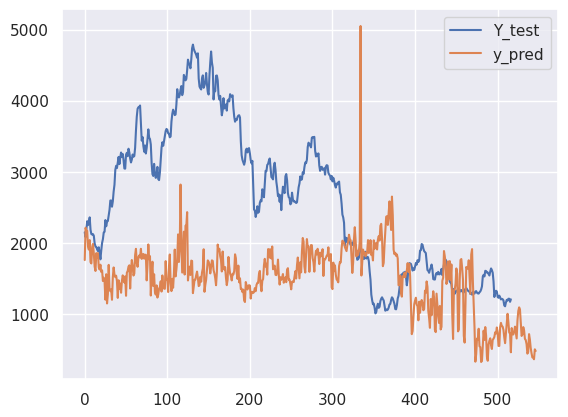

In [30]:
pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred']).plot()

In [31]:
pre_df.to_csv("../result/ANN/eth_NN.csv")

In [32]:

!kdeconnect-cli -n TAS-AN00 --ping-msg 'Script complete!'

error: No such object path '/modules/kdeconnect/devices/d3f6a622d8051137/ping'
